In [8]:
from dotenv import load_dotenv

load_dotenv()

True

In [9]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [10]:
from langsmith import Client

client = Client()

In [11]:
from typing import Literal
from typing_extensions import TypedDict
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

class AgentState(TypedDict):
    query: str
    answer: str

In [12]:
def basic_generate(state: AgentState) -> AgentState:
    """
    'basic_generate' Node
    : 사용자의 질문에 대한 응답을 생성한다.

    Args:
        - state(AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 생성된 응답이 추가된 state
    """
    
    query = state['query']
    
    # LLM에게 직접 질문
    ai_message = llm.invoke(query)
    
    return {'answer': ai_message}

In [13]:
from pydantic import BaseModel, Field

class Router(BaseModel):
    target: Literal['income_tax', 'real_estate_tax', 'llm'] = Field(
        description="The target for the query to answer"
    )

structured_llm = llm.with_structured_output(Router)

In [14]:
route_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'real_estate_tax', or 'llm'.

if you think the question is not related to either 'income_tax' or 'real_estate_tax'.
you can route it to 'llm'.

- 'income_tax' contains information about income tax up to December 2024.
- 'real_estate_tax' contains information about real estate tax up to December 2024.
"""

route_prompt = ChatPromptTemplate.from_messages([
    ('system', route_system_prompt),
    ('user', '{query}')
])

def route(state: AgentState) -> Literal['income_tax', 'real_estate_tax', 'llm']:
    """
    'route' Node
    : 사용자 질문의 적절한 경로를 결정한다.

    Args:
        - state(AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        - Literal['income_tax', 'real_estate_tax', 'llm']: 질문을 처리하기 위한 경로를 나타내는 문자열
    """
    
    query = state['query']
    
    # 라우터 체인
    route_chain = route_prompt | structured_llm
    ai_message = route_chain.invoke({'query': query})
    
    return ai_message.target


In [15]:
from langgraph.graph import StateGraph, START, END
from graph.income_tax_graph import graph as income_tax_graph
from graph.real_estate_tax_graph import graph as real_estate_tax_graph

graph_builder = StateGraph(AgentState)

# nodes
graph_builder.add_node('basic_generate', basic_generate)
graph_builder.add_node('income_tax_agent', income_tax_graph)
graph_builder.add_node('real_estate_tax_agent', real_estate_tax_graph)

# edges
graph_builder.add_conditional_edges(
    START,
    route,
    {
        'llm': 'basic_generate',
        'income_tax': 'income_tax_agent',
        'real_estate_tax': 'real_estate_tax_agent'
    }
)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('income_tax_agent', END)
graph_builder.add_edge('real_estate_tax_agent', END)

In [16]:
graph = graph_builder.compile()

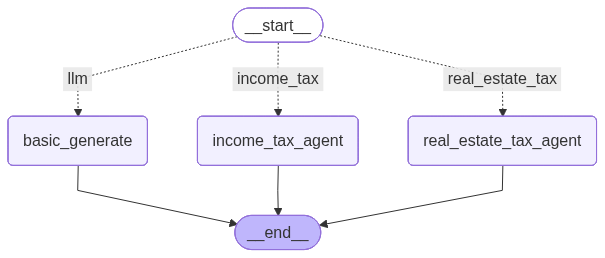

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
query1 = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있다면 세금이 얼마인가요?"
query2 = "연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?"
query3 = "대한민국의 수도는 어디인가요?"
initial_state = {'query': query3}

graph.invoke(initial_state)

{'query': '대한민국의 수도는 어디인가요?',
 'answer': AIMessage(content='대한민국의 수도는 서울입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 16, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bbc38b4db', 'id': 'chatcmpl-Ctz45QEBja3OTVtKQt84ODVNg69XO', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b84c1-2507-7261-87b2-3b2ef6134dec-0', usage_metadata={'input_tokens': 16, 'output_tokens': 8, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}